In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAperture
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
import scipy.odr as odr

In [642]:
im_test='./WCS_Solved/UGC9374/UGC9374_B.fits'
image=fits.open(im_test)[0].data
hdr=fits.open(im_test)[0].header
wcs=WCS(hdr)
data=image.byteswap().newbyteorder()
targets={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9374': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}
target=im_test.split('/')[-2]
target_x,target_y=wcs.world_to_pixel(targets[target])


In [643]:
references=np.transpose(np.genfromtxt(f'./Reference_Cats/Ref_{target}.csv',delimiter=',',skip_header=1,filling_values=np.NaN))
print(references[16][22])
masked=[7,17,36,48,4,1,15]
full_masked=[]
for ind in range(0,len(references[0])):
    if np.isnan(references[16][ind]) or np.isnan(references[19][ind]) or np.isnan(references[4][ind]) or np.isnan(references[7][ind]):
        full_masked.append(ind)
        print('test',ind)
        continue
    c=SkyCoord(ra=references[0][ind],dec=references[2][ind],unit='deg')
    ap_size=3
    test_x_ind,test_y_ind=wcs.world_to_pixel(c)
    test_x_ind_int=int(test_x_ind)
    test_y_ind_int=int(test_y_ind)
    if test_x_ind<20 or test_y_ind<20 or test_x_ind>image.shape[1]-20 or test_y_ind>image.shape[0]-20 or image[test_y_ind_int,test_x_ind_int]>100_000 or ind in masked:
        full_masked.append(ind)
        print(ind)
        continue
    size=15
    plt.plot(range(test_y_ind_int-size,test_y_ind_int+size),image[test_y_ind_int-size:test_y_ind_int+size,test_x_ind_int])
    plt.axvline(x=test_y_ind,color='r',ls='--')
    plt.axvline(x=test_y_ind-ap_size,color='black',ls='--')
    plt.axvline(x=test_y_ind+ap_size,color='black',ls='--')
    plt.savefig(f'./Diagnostics/{ind}.png')
    plt.close()
positions=[]
for ind,(ra,dec) in enumerate(zip(references[0],references[2])):
    if ind not in full_masked:
        positions.append(wcs.world_to_pixel(SkyCoord(ra=ra,dec=dec,unit='deg')))
r_mags=references[16]
dr_mags=references[17]
i_mags=references[19]
di_mags=references[20]
V_mags=references[4]
dV_mags=references[5]
B_mags=references[7]
dB_mags=references[8]
R_mags=[]
dR_mags=[]
a=-0.153
b=0.117
da=0.003
db=0.03
for r,dr,i,di in zip(r_mags,dr_mags,i_mags,di_mags):
   R=a*(r-i)-b+r
   dR=np.sqrt(((r-i)**2)*da**2+db**2+((a+1)*dr)**2+(a*di)**2)
   R_mags.append(R)
   dR_mags.append(dR)
Reduced_R_mags=[R_mags[ind] for ind in range(len(R_mags)) if ind not in full_masked]
Reduced_dR_mags=[dR_mags[ind] for ind in range(len(R_mags)) if ind not in full_masked]
Reduced_B_mags=[B_mags[ind] for ind in range(len(B_mags)) if ind not in full_masked]
Reduced_V_mags=[V_mags[ind] for ind in range(len(V_mags)) if ind not in full_masked]
Reduced_dB_mags=[dB_mags[ind] for ind in range(len(dB_mags)) if ind not in full_masked]
Reduced_dV_mags=[dV_mags[ind] for ind in range(len(dV_mags)) if ind not in full_masked]
if hdr['FILTER']=='R':
    Ref_mags=Reduced_R_mags
    dRef_mags=Reduced_dR_mags
if hdr['FILTER']=='B':
    Ref_mags=Reduced_B_mags
    dRef_mags=Reduced_dB_mags
if hdr['FILTER']=='V':
    Ref_mags=Reduced_V_mags
    dRef_mags=Reduced_dV_mags
def Linfunc(beta,x):
    return x+beta[0]

15.379
1
4
7
test 9
15
17
test 25
test 29
test 30
test 31
36
test 38
test 42
test 44
48
49


In [644]:
bkg = sep.Background(data)
data_sub=data-bkg.globalback
#objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True)
objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True,deblend_cont=1)#use if no blending wanted
dists=np.sqrt((objects['x']-target_x)**2+(objects['y']-target_y)**2)
obj=np.argmin(dists)
#print(objects[obj])
x=objects['x'][obj]
y=objects['y'][obj]
a=objects['a'][obj]
b=objects['b'][obj]
theta=objects['theta'][obj]
obj_seg=seg_map[int(y),int(x)]
bkg_mask=np.zeros(data.shape,dtype=bool)
masked_pixels=0
for i in range(len(data)):
    for j in range(len(data[i])):
        if seg_map[i][j]!=0:
            bkg_mask[i][j]=True
            masked_pixels+=1
newbkg=sep.Background(data,mask=bkg_mask)
bkg_mean,bkg_med,bkg_std=sigma_clipped_stats(newbkg,sigma=2)
print(bkg_mean,bkg_med,bkg_std)

49.43674721827033 49.41927719116211 0.23502373167727778


# Galaxy Diagnostics #

(780.0, 1180.0)

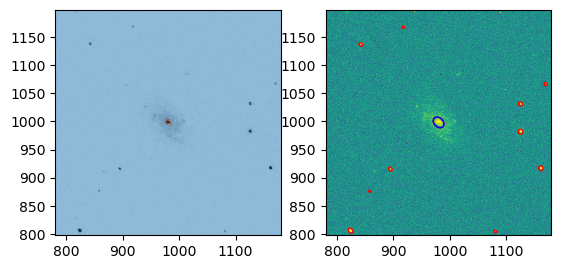

In [645]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image,vmin=bkg_med,vmax=2*bkg_med,cmap='Greys')
ax1.imshow(seg_map,vmin=obj_seg-1,vmax=obj_seg+1,cmap='tab20',alpha=0.5)
ax1.set_ylim(int(y)-200,int(y)+200)
ax1.set_xlim(int(x)-200,int(x)+200)
m, s = np.mean(data_sub), np.std(data_sub)
im = ax2.imshow(data_sub, interpolation='nearest', cmap='viridis',
               vmin=m-s, vmax=m+s, origin='lower')
areas=[]
# plot an ellipse for each object
for i in range(len(objects)):
    areas.append(np.pi*objects['a'][i]*objects['b'][i])
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax2.add_artist(e)
e1 = Ellipse(xy=(objects['x'][obj], objects['y'][obj]),
                width=6*objects['a'][obj],
                height=6*objects['b'][obj],
                angle=objects['theta'][obj] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax2.add_artist(e1)
plt.ylim(int(y)-200,int(y)+200)
plt.xlim(int(x)-200,int(x)+200)

# Galaxy Flux #

In [646]:
mask = np.zeros(data.shape, dtype=bool)
for i in range(len(mask)):
    for j in range(len(mask[i])):
        #if seg_map[i][j]!=0:
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            mask[i][j]=True

In [647]:
kronrad, krflag = sep.kron_radius(data, [x], [y], [a], [b], [theta], 6.0,segmap=seg_map,seg_id=[obj_seg])
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
print('Area=',aper.area)
phot_table = aperture_photometry(image, aper,mask=mask)
net=phot_table['aperture_sum'][0]-aper.area_overlap(image,mask=mask)*bkg_med
SN_gal=net/np.sqrt(net+aper.area_overlap(image,mask=mask)*bkg_med)
print('Flux=',net)
print('S/N',SN_gal)

Area= 2830.337539870862
Flux= 32212.264620809205
S/N 77.65136940619539


# Mask Check #

In [648]:
test=image.copy()
trues=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        #if seg_map[i][j]!=0:
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            test[i][j]=bkg_med
            trues+=1
print(trues)

8371


(730.0, 1230.0)

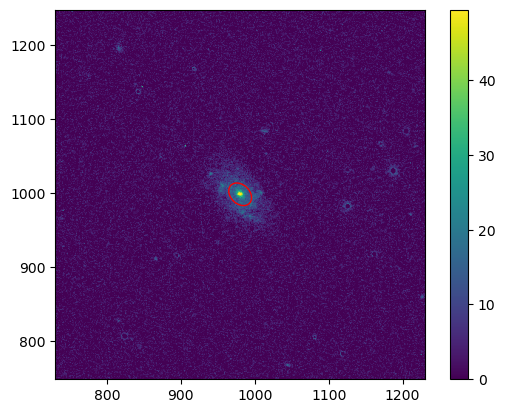

In [649]:
fig, ax = plt.subplots()
im=ax.imshow(test-bkg_med,vmin=0,vmax=bkg_med,cmap='viridis')
fig.colorbar(im)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax.add_artist(e_app)
plt.ylim(int(y)-250,int(y)+250)
plt.xlim(int(x)-250,int(x)+250)

# Reference Star Diagnostics #

(0.0, 2048.0)

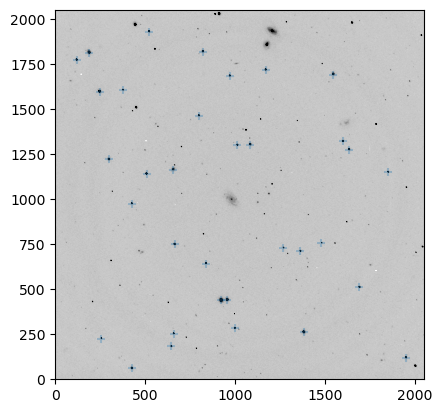

In [650]:
plt.imshow(image,vmin=0.5*bkg_med,vmax=2*bkg_med,cmap='Greys')
plt.scatter([el[0] for el in positions],[el[1] for el in positions],marker='+',alpha=0.3)
plt.ylim(0, image.shape[0])
plt.xlim(0, image.shape[1])

In [651]:
radii = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
apertures = [CircularAperture(positions, r=r) for r in radii]
phot_table = aperture_photometry(image, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
#print(phot_table)

In [652]:
annulus_aperture =CircularAnnulus(positions, r_in=12., r_out=15.)
bkg_table = aperture_photometry(image, annulus_aperture)
for col in bkg_table.colnames:
    bkg_table[col].info.format = '%.8g'
#print(bkg_table)


In [653]:
ref_bkg_mean = bkg_table['aperture_sum'] / annulus_aperture.area
snr = np.array([])
snr1=[]
index = 0
for col in phot_table.colnames[3:]:
    ref_bkg_total = ref_bkg_mean * apertures[index].area
    net_star = phot_table[col] - ref_bkg_total
    snr_arr=net_star/np.sqrt(net_star+ref_bkg_total)
    snr1.append(snr_arr)
    snr = np.append(snr, net_star / np.sqrt(net_star + ref_bkg_total))
    index += 1

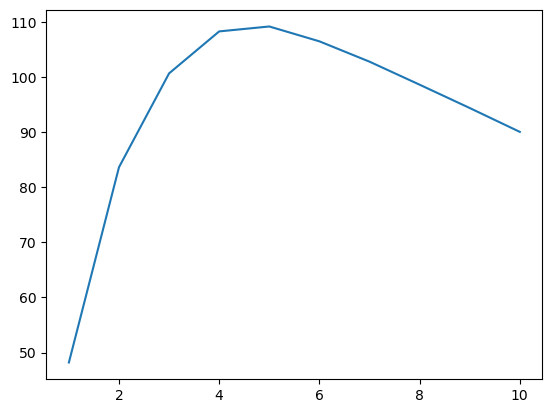

In [654]:
plt.plot(radii,[np.median(el) for el in snr1])

In [655]:
print(radii[np.argmax([np.median(el) for el in snr1])])
circ_ap =CircularAperture(positions, r=radii[np.argmax([np.median(el) for el in snr1])])
#circ_ap =CircularAperture(positions, r=10)
annulus_ap = CircularAnnulus(positions, r_in=12., r_out=15.)
aps=[circ_ap,annulus_ap]
phot_table = aperture_photometry(image, aps)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
ref_bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
print(np.median(ref_bkg_mean))
ref_bkg_total=ref_bkg_mean*circ_ap.area
adjusted_bkg_total=ref_bkg_mean*aper.area_overlap(image,mask=mask)
net_star=phot_table['aperture_sum_0']-ref_bkg_total
adjusted_net_star=phot_table['aperture_sum_0']*(aper.area_overlap(image,mask=mask)/circ_ap.area)-adjusted_bkg_total
#inst_mags=-2.5*np.log10(adjusted_net_star)
snr_arr=net_star/np.sqrt(net_star+ref_bkg_total)
inst_mags=-2.5*np.log10(net_star)
#snr_arr=net_star/np.sqrt(net_star+ref_bkg_total)
#print(inst_mags)
print(np.median(snr_arr))
print(np.mean(snr_arr))
print(np.max(snr_arr))
print(np.argmin(snr_arr))
print(np.min(snr_arr))
#print(phot_table)

5
50.28868814045936
109.14783832008166
147.10790763491678
554.6665702206556
20
36.498352279674414


In [656]:
print(len(inst_mags))
print(len(Ref_mags))
print(len(snr_arr))
print(len(dRef_mags))
for num,el in enumerate(dRef_mags):
    if el==0:
        dRef_mags[num]=np.max(dRef_mags)
        print('test')
print(np.min(dRef_mags))

34
34
34
34
0.011


In [657]:
model=odr.Model(Linfunc)
mydata = odr.RealData(inst_mags, Ref_mags, sx=1/snr_arr, sy=dRef_mags)
myodr = odr.ODR(mydata, model, beta0=[27])
myoutput = myodr.run()
myoutput.pprint()

Beta: [26.55651405]
Beta Std Error: [0.01115104]
Beta Covariance: [[2.95263195e-05]]
Residual Variance: 4.211351804413286
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


26.54549145054812
26.55731059159049
m= 15.286460900211926
dm= 0.017034978192221495


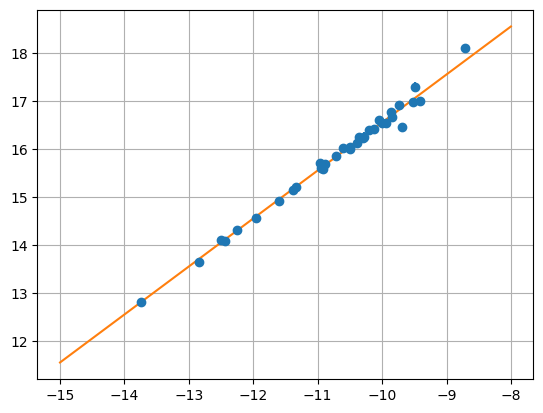

In [658]:
plt.errorbar(inst_mags,Ref_mags,xerr=(1/snr_arr), yerr=dRef_mags,fmt='o')
test_space=np.linspace(-15,-8,100)
plt.plot(test_space,Linfunc(myoutput.beta,test_space))
plt.grid(True)
print(np.nanmedian(Ref_mags-inst_mags))
print(np.nanmean(Ref_mags-inst_mags))
print('m=',Linfunc(myoutput.beta,-2.5*np.log10(net)))
print('dm=',np.sqrt((1/SN_gal)**2+myoutput.sd_beta[0]**2))
#print(-2.5*np.log10(net))